In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df1=pd.read_csv("Fx.csv",header=-1) #fnq= 41 oq=61  df1[fnq][oq]
df3=pd.read_csv("Fz.csv",header=-1)
df5=pd.read_csv("My.csv",header=-1)
matrixList=[df1,df3,df5]

In [3]:
ddf1=pd.read_csv("Fxd.csv",header=-1) #fnq= 41 oq=61  df1[fnq][oq]
ddf3=pd.read_csv("Fzd.csv",header=-1)
ddf5=pd.read_csv("Myd.csv",header=-1)
dmatrixList=[ddf1,ddf3,ddf5]

In [4]:
gg = 9.8
rho = 997
beta = 0.25
t = 0
dt = 0.1

In [8]:
class Wave:
    amp = 0.
    k = 0.
    omega = 0.
    phase = 0.
    def __init__(self, a, o, p):
        self.amp = a
        self.omega = o
        self.k = o*o/gg
        self.phase = p
    
    def get(self,x, t):
        return self.amp*math.sin(self.omega*t + self.k*x + self.phase)

    def calcF(self,x,t,Fn,omega_e,axis):
        fni = round(Fn/(1./40)) #0~40 
        omi = round(omega_e/(1./4)) #0~60
        if(fni>=41): print(fni)
        if(omi>=61): print(omi)
        # print(self.omega)
        j = round((axis-1)/2)
        # print(fni)
        # print(omi)
        coeff =  matrixList[j][fni][omi]*100 #N/cm -> N/m
        poffset= dmatrixList[j][fni][omi]
        output = coeff*self.amp*math.sin(self.omega*t + self.k*x + self.phase + poffset)  
        return output #N

In [175]:
class JONSWAP:
    N = 0    
    T_1 = 0
    H_third = 0
    waves = []
    delta_omega = 0
    max_omega = 0
    def __init__(self, N, T_1, H_third):
        self.waves = []
        self.N = N
        self.T_1 = T_1
        self.H_third = H_third
        self.max_omega = 4*math.pi/self.T_1 * 2
        self.delta_omega = self.max_omega/self.N
        for i in range(self.N):
            new_omega = self.delta_omega*(0.5+i)+random.uniform(-self.delta_omega/2,self.delta_omega/2)
            new_wave = Wave(self.getWaveHeight(new_omega),new_omega,random.uniform(0,2*math.pi))
            self.waves.append(new_wave)

    def getWaveHeight(self,omega):
        if(omega!=0):
            sigma = 0.08
            Y = math.exp(-((0.191*omega*self.T_1-1)/(math.sqrt(2)*sigma))**2) 
            S = 155*(self.H_third**2)/(self.T_1**4*omega**5)*math.exp(-944/(self.T_1**4*omega**4))*3.3**Y
            A = math.sqrt(2*S*self.delta_omega)
        else:
            A = 0
            S = 0
        return A
        # return S

    def get(self,x,t):
        waveheight = 0
        for w in self.waves:
            waveheight += w.get(x,t)
        return waveheight

0.006283185307179587


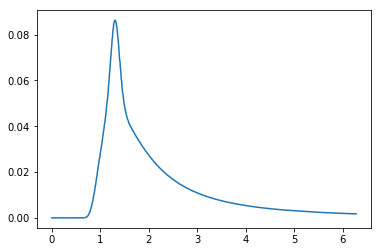

In [176]:
jj = JONSWAP(1000,4,2)
x=np.arange(0,jj.N*jj.delta_omega,jj.delta_omega)
y=[]
for i in range(jj.N):
    y.append(jj.waves[i].amp)

plt.plot(x,y)
print(jj.delta_omega)

In [11]:
class Water:
    waves = []
    def __init__(self, num, random_wave):
        self.waves = []
        if(random_wave==True):
            for i in range(num):
                newWave = Wave(random.uniform(0.01,0.05),random.uniform(1.2,3),random.uniform(1,10))
                self.waves.append(newWave)
        elif(num==0):
            self.waves.append(Wave(0,0,0))
        else:
            self.waves.append(Wave(0.1,10,0))
            
    def get(self,x,t):
        waveheight = 0
        for w in self.waves:
            waveheight += w.get(x,t)
        return waveheight

In [12]:
def calcFn(u,L):
    return math.fabs(u)/math.sqrt(9.8*L)

In [13]:
class Particle:
    posx = 0
    posz = 0
    velx = 0
    velz = 0
    accx = 0
    accz = 0
    
    angle = 0
    anglevel = 0
    angleacc = 0

    pl = 3.11
    ph = 0.34
    pw = 0.94
    pv = 0.0878
    mass = pv*100
    cgh = 0.340

    draught = 0

    A11 = 0.3 * rho * pv
    A13 = 0
    A31 = 0
    A53 = 0.1 * rho * pv * pl
    A35 = 0.05* rho * pv * pl
    A33 = 0.3 * rho * pv
    A51 = 0.01* rho * pv * pl
    A55 = 0.07* rho * pv * pl * pl
    B11 = 2.0* rho * pv * math.sqrt(gg/pl)
    B53 = 0.05* rho * pv * pl * math.sqrt(gg/pl)
    B35 = 0.4* rho * pv * pl * math.sqrt(gg/pl)
    B33 = 2.0* rho * pv * math.sqrt(gg/pl)
    B55 = 0.4* rho * pv * pl * pl * math.sqrt(gg/pl)
    C11 = 0
    C53 = 0
    C35 = 0
    C33 = 11014
    C55 = 6233

    def __init__(self,x,z):
        self.posx = x
        self.posz = z
        self.accx = 0
        self.accz = 0
        self.velx = 0
        self.velz = 0

    def calcAcc(self,thr_f):
        tFx=0
        tFz=0
        tMy=0

        average_waveheight = 0
        res = 50
        for i in range(res):
          average_waveheight += ww.get(self.posx-self.pl/2+self.pl/res*i,t)
        average_waveheight = average_waveheight/res
        self.draught = min(max(average_waveheight-(self.posz-self.ph),0), self.ph)
            
        nx = math.cos(self.angle - math.pi/2)
        ny = math.sin(self.angle - math.pi/2)

        Fn = calcFn(self.velx,self.pl)
        # print(Fn)

        tFz -= self.mass*gg #Gravity
        
        if(self.draught>0):
            tFx += thr_f * math.cos(self.angle)
            tFz += thr_f * math.sin(self.angle)

            for w in ww.waves:
                omega_e = w.omega + w.omega**2 * self.velx / gg
                tFx += w.calcF(self.posx,t,Fn,omega_e,axis=1)
                tFz += w.calcF(self.posx,t,Fn,omega_e,axis=3)
                tMy += w.calcF(self.posx,t,Fn,omega_e,axis=5)

            z_t = self.posz - 0.185
            heave = (tFz - self.B33*(self.velz + dt/2*self.accz) - self.C33*(z_t+dt*self.velz+(0.5-beta)*dt*dt*self.accz)) / ((self.mass+self.A33) + dt/2*self.B33 + beta*dt*dt*self.C33)
            surge = (tFx - self.B11*(self.velx + dt/2*self.accx)) / ((self.mass+self.A11) + dt/2*self.B11)
            pitch = (tMy - self.B55*(self.anglevel + dt/2*self.angleacc) - self.C55*(self.angle+dt*self.anglevel+(0.5-beta)*dt*dt*self.angleacc)) / ((self.mass+self.A55) + dt/2*self.B55 + beta*dt*dt*self.C55)

            self.accx = surge
            self.accz = heave
            self.angleacc = pitch
        else:
          self.accx = 0
          self.accz = -9.8


    def update(self,thr_f):
      self.calcAcc(thr_f)
      self.velx += self.accx*dt
      self.velz += self.accz*dt
      self.anglevel += self.angleacc*dt
      self.posx += self.velx*dt
      self.posz += self.velz*dt
      self.angle += self.anglevel*dt
      # print("x=" + "{:.2f}".format(self.posx))
      # print("z=" + "{:.2f}".format(self.posz))

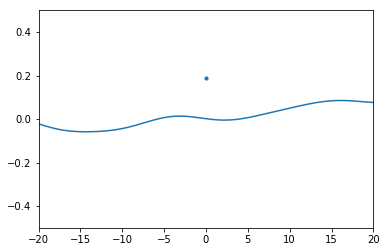

In [187]:
# ww = Water(100,random_wave=True)
ww = JONSWAP(100,10,0.5)
xdata = np.arange(-20,20,0.01)
ydata = np.array([ww.get(x,t) for x in xdata])
fig, ax = plt.subplots()
ax.set_xlim(-20.0,20.0)
ax.set_ylim(-0.5,0.5)
# ax.set_aspect('equal', adjustable='box')

ax.plot(xdata,ydata)
ax.scatter(pp.posx,pp.posz,s=10)
# t+=1
# pp.update(en_thr=False)


In [188]:
pp = Particle(0,0.19)
dt = 0.01
t=0
dl = []
xl = []
xvl = []
xal = []
zl = []
zvl= []
zal =[]
eng = []
pl = []

wave_heights = []
wave_interval = []

tmp_max=0
tmp_min=0
tmp_ts=0

upcross_num =0

last_waveheight = 0
current_waveheight = 0
for i in range(100000):
    # zero upcross
    current_waveheight = ww.get(0,t)
    if(i==0): last_waveheight = current_waveheight

    if(last_waveheight<=0 and current_waveheight>0):
        # save last wave info (exclude first upcross)
        # reset tmp variables

        if(upcross_num==0):
            tmp_ts = t
        else: 
            wave_heights.append(tmp_max-tmp_min)
            wave_interval.append(t-tmp_ts)
            tmp_max = 0
            tmp_min = 0
            tmp_ts = t
        upcross_num += 1

    if(current_waveheight > tmp_max): tmp_max = current_waveheight
    if(current_waveheight < tmp_min): tmp_min = current_waveheight
    last_waveheight = current_waveheight
    
    # ship
    # pp.update(20)
    # dl.append(pp.draught)
    # xl.append(pp.posx)
    # xvl.append(pp.velx)
    # xal.append(pp.accx)
    # zl.append(pp.posz)
    # zvl.append(pp.velz)
    # zal.append(pp.accz)
    # pl.append(pp.angle)
    # eng.append(pp.mass*pp.velz**2)
    t+=dt

0.4851128709293848
31.961133504217088


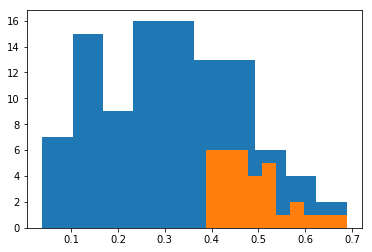

In [189]:
sorted_wave_heights = sorted(wave_heights)
H_third_list = sorted_wave_heights[2*round(len(sorted_wave_heights)/3):]

plt.hist(sorted_wave_heights)
plt.hist(H_third_list)
print(sum(H_third_list)/len(H_third_list))
print(sum(sorted_wave_heights))

9.766732673259767


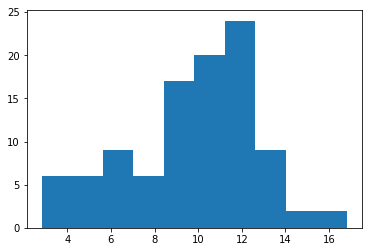

In [190]:
plt.hist(wave_interval)
print(sum(wave_interval)/len(wave_interval))

In [191]:
fig, ax = plt.subplots()
tdata = np.arange(0,10000*dt,dt)
# ax.set_ylim(-0.5,0.5)
ax.plot(tdata,xl,label="pos")
# ax.plot(tdata,zvl,label="vel")
# ax.plot(tdata,zal,label="acc")
# ax.plot(tdata,dl,label="draught")
# ax.plot(tdata,eng,label="energy")
# ax.plot(tdata,pl,label="pitch angle")
# ax.plot(xl,zl)

# ax.plot(tdata,xvl,label="vel")

ax.legend()

ValueError: x and y must have same first dimension, but have shapes (10000,) and (0,)

Text(0.5, 1.0, 'xvel')

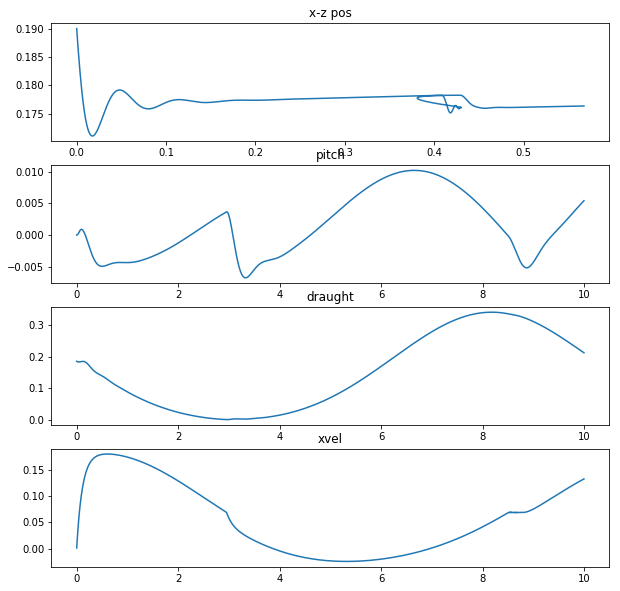

In [76]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,figsize=(10,10))

ax1.plot(xl,zl)
ax1.set_title('x-z pos')

ax2.plot(tdata,pl)
ax2.set_title('pitch')

ax3.plot(tdata,dl)
ax3.set_title('draught')

ax4.plot(tdata,xvl)
ax4.set_title('xvel')


In [77]:
# ww = Water(10,random_wave=True)
# pp = Particle(0,0.19)
# dt = 0.001
# t=0
# dl = []
# xl = []
# xvl = []
# xal = []
# zl = []
# zvl= []
# zal =[]
# eng = []
# pl = []

# for i in range(10000):
#     pp.update(80)
#     dl.append(pp.draught)
#     xl.append(pp.posx)
#     xvl.append(pp.velx)
#     xal.append(pp.accx)
#     zl.append(pp.posz)
#     zvl.append(pp.velz)
#     zal.append(pp.accz)
#     pl.append(pp.angle)
#     eng.append(pp.mass*pp.velz**2)
#     t+=dt

In [78]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,figsize=(10,10))

# ax1.plot(xl,zl)
# ax1.set_title('x-z pos')

# ax2.plot(tdata,pl)
# ax2.set_title('pitch')

# ax3.plot(tdata,dl)
# ax3.set_title('draught')

# ax4.plot(tdata,xvl)
# ax4.set_title('xvel')

In [79]:

# xdata = np.arange(-20,20,0.01)
# ydata = np.array([ww.get(x,t) for x in xdata])
# fig, ax = plt.subplots()
# ax.set_xlim(-20.0,20.0)
# ax.set_ylim(-0.5,0.5)
# # ax.set_aspect('equal', adjustable='box')

# ax.plot(xdata,ydata)
# ax.scatter(pp.posx,pp.posz,s=10)
# t+=1
# # pp.update(en_thr=False)